<center><h1 style="font-size:300%; background-color:skyblue; color:grey; padding:60px; font-family:Garamond;"><b>MACHINE TRANSLATION Using Seq2Seq Modelling</b></h1></center>

<center><h1 style="font-size:200%; background-color:white; color:lightwhite; padding:15px; font-family:Garamond;">“If you talk to a man in a language he understands, that goes to his head. If you talk to him in his own language, that goes to his heart.”<br> – <b>Nelson Mandela</b></h1></center>

<img src='https://miro.medium.com/max/875/1*WWXJ0w6YByfPA9KKmDx2Ug.jpeg' style="width:1200px;height:600px;">

<center><h1 style="font-size:200%; background-color:skyblue; color:black; padding:15px; font-family:Garamond;"><b>Intro to Notebook</b></h1></center>

<p style="font-size:150%;">The objective is to Explain How Seq 2 Seq and LSTMs are used for Machine Translations using an example dataset of converting a German sentence to its English counterpart.</p>

<h1> What is Seq2Seq Modelling ?</h1>

<ul>
    <li style="font-size:150%;">Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to German). Our aim is to translate given sentences from German language to English.</li>
    <li style="font-size:150%;">Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, DNA sequence modeling, among others.</li>
    <li style="font-size:150%;">Here, both the input and output are sentences. In other words, these sentences are a sequence of words going in and out of a model. This is the basic idea of Sequence-to-Sequence modeling. The figure below tries to explain this method.</li>
</ul>

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/01/enc_dec_simple.png"></center>

<h2>  Here's how it works:</h2>

<ul>
    <li style="font-size:150%;">Feed the embedding vectors for source sequences (German), to the encoder network, one word at a time.</li>
    <li style="font-size:150%;">Encode the input sentences into fixed dimension state vectors. At this step, we get the hidden and cell states from the encoder LSTM, and feed it to the decoder LSTM.</li>
    <li style="font-size:150%;">These states are regarded as initial states by decoder. Additionally, it also has the embedding vectors for target words (English).</li>
    <li style="font-size:150%;">Decode and output the translated sentence, one word at a time. In this step, the output of the decoder is sent to a softmax layer over the entire target vocabulary.</li>
</ul>

<h1> What is LSTM ?</h1>

<ul>
    <li style="font-size:150%;">Long Short-Term Memory (LSTM) networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation. In an LSTM network, three gates are present:</li>
</ul>

<center><img src="https://miro.medium.com/max/700/1*MwU5yk8f9d6IcLybvGgNxA.jpeg"></center>

<ul>
    <li style="font-size:150%;"><b>Input gate —</b> discover which value from input should be used to modify the memory. Sigmoid function decides which values to let through 0,1. and tanh function gives weightage to the values which are passed deciding their level of importance ranging from-1 to 1.</li>
    <center><img src="https://miro.medium.com/max/500/1*k1lxwjsxxn8O4BEiVlQNdg.png"></center>
    <li style="font-size:150%;"><b>Forget gate —</b> discover what details to be discarded from the block. It is decided by the sigmoid function. it looks at the previous state(ht-1) and the content input(Xt) and outputs a number between 0(omit this)and 1(keep this)for each number in the cell state Ct−1.</li>
    <center><img src="https://miro.medium.com/max/500/1*bQnecA5sy_eepNkL8I-95A.png"></center>
    <li style="font-size:150%;"><b>Output gate —</b> the input and the memory of the block is used to decide the output. Sigmoid function decides which values to let through 0,1. and tanh function gives weightage to the values which are passed deciding their level of importance ranging from-1 to 1 and multiplied with output of Sigmoid.</li>
    <center><img src="https://miro.medium.com/max/700/1*s8532P11PgGi2sZqikZ2kA.png"></center>
</ul>

<center><h1 style="font-size:200%; background-color:skyblue; color:black; padding:15px; font-family:Garamond;"><b>Let's start the Implementation</b></h1></center>

### 1. Import the Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

### 2. Load the Data 

In [3]:
# defining a function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [5]:
# defining a function to split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [6]:
# Loading the dataset (deu.txt) from the Kaggle site

data = read_text("../input/bilingual-sentence-pairs/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
# Let's get a sample of the dataset (50000/150000)
deu_eng = deu_eng[:50000,:]

<ul>
    <li style="font-size:150%;">The actual data contains over 150,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model. You can change this number as per your system’s computation power.</li>
</ul>

### 3. Text Cleaning / Preprocessing

<ul>
    <li style="font-size:150%;">We will get rid of the punctuation marks and then convert all the text to lower case.</li>
</ul>

In [8]:
# Remove punctuation

deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

# Displaying the 50000 sentence-pairs
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [9]:
# convert text to lowercase

for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

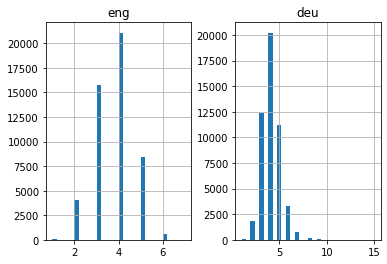

In [10]:
# creating empty lists to store the new text of each language
# after removing the punctuation and converting the text to lowercase

eng_l = []
deu_l = []

# Creating a for loop to iterate through english language
# to populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))
# creating a for loop to iterate through german language
# to populate the lists with sentence lengths
for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))
# Creating a df (pandas dataframe) out of the dictionary
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

#creating a histogram to see the data distribution
length_df.hist(bins = 30)
plt.show()

<ul>
    <li style="font-size:150%;">A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.</li>
    <li style="font-size:150%;">Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.</li>
    <li style="font-size:150%;">Prepare tokenizers for both the German and English sentences</li>
</ul>

In [11]:
# defining a function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


<ul>
    <li style="font-size:150%;">We tokenized the data — i.e., converted the text to numerical values. This allows the neural network to perform operations on the input data.</li>
    <li style="font-size:150%;">When we run the tokenizer, it creates a word index, which is then used to convert each sentence to a vector.</li>

In [15]:
# Since sentences can vary greatly in length, padding is used to ensure
# all sequences in a batch have the same length.

# defomomg a function for encoding the sequences

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
   
    # padding the sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

<ul>
    <li style="font-size:150%;">When we feed our sequences of word IDs into the model, each sequence needs to be the same length. To achieve this, padding is added to any sequence that is shorter than the max length (i.e. shorter than the longest sentence).</li>
</ul>

<center><img src="https://miro.medium.com/max/1728/0*6jZTOE0P7_i7N8pn.png"></center>

<center><h1 style="font-size:200%; background-color:skyblue; color:black; padding:15px; font-family:Garamond;"><b>Model Building</b></h1></center>

<p style="font-size:150%;">CODE REFERENCE: https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/</p>

<p style="font-size:170%;">First, let’s breakdown the architecture of an RNN at a high level. Referring to the diagram above, there are a few parts of the model we to be aware of:</p>

<ul>
    <li style="font-size:150%;">Inputs. Input sequences are fed into the model with one word for every time step. Each word is encoded as a unique integer so that it maps to the German dataset vocabulary.</li>
    <li style="font-size:150%;">Embedding Layers. Embeddings are used to convert each word to a vector. The size of the vector depends on the complexity of the vocabulary.</li>
    <li style="font-size:150%;">LSTM Layer (Encoder). This is where the context from word vectors in previous time steps is applied to the current word vector.</li>
    <li style="font-size:150%;">Dense Layers (Decoder). These are typical fully connected layers used to decode the encoded input into the correct translation sequence.</li>
    <li style="font-size:150%;">he outputs are returned as a sequence of integers or one-hot encoded vectors which can then be mapped to the English dataset vocabulary.</li>
</ul>
    
    
<center><h1 style="font-size:150%;">Model Architecture</h1></center>
<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/01/architecture.png"></center>

In [16]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

<ul>
    <li style="font-size:150%;">It’s time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. This has to be done for both the train and test datasets.</li>

In [18]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

### 5.Define the Model

In [19]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [20]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [21]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

<ul>
    <li style="font-size:150%;">We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.</li>
    <li style="font-size:150%;">Here I have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.</li>
               
</ul>

### 6.Fit the Model

<ul>
    <li style="font-size:150%;">ModelCheckpoint() function to save the model with the lowest validation loss. I personally prefer this method over early stopping.</li>
</ul>

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 133s 2s/step - loss: 4.3598 - val_loss: 2.8280

Epoch 00001: val_loss improved from inf to 2.82799, saving model to model.h1.24_jan_19
Epoch 2/30
63/63 [==============================] - 126s 2s/step - loss: 2.7836 - val_loss: 2.7476

Epoch 00002: val_loss improved from 2.82799 to 2.74755, saving model to model.h1.24_jan_19
Epoch 3/30
63/63 [==============================] - 126s 2s/step - loss: 2.6160 - val_loss: 2.5510

Epoch 00003: val_loss improved from 2.74755 to 2.55102, saving model to model.h1.24_jan_19
Epoch 4/30
63/63 [==============================] - 126s 2s/step - loss: 2.4146 - val_loss: 2.4091

Epoch 00004: val_loss improved from 2.55102 to 2.40912, saving model to model.h1.24_jan_19
Epoch 5/30
63/63 [==============================] - 126s 2s/step - loss: 2.2704 - val_loss: 2.3293

Epoch 00005: val_loss improved from 2.40912 to 2.32927, saving model to model.h1.24_jan_19
Epoch 6/30
63/63 [==============================]

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

#### 7.Prediction on unseen data

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
# print 15 rows randomly
pred_df.head(15)

### Conclusion: 
1. Machine translation is used to convert text from one language to another.
2. The lab uses a German-to-English dataset to perform translation.
3. Sequence-to-sequence models are effective for language translation tasks.
4. Long Short-Term Memory (LSTM) networks help in processing sequences of words.
5. The encoder processes input sentences into a context vector.
6. The decoder uses this context to predict the translated output.
7. The quality of predictions depends on the size and quality of the dataset.
8. The model improves with more training examples.
9. Translations often fail when the model hasn't seen similar examples during training.
10. Word order and grammar rules are challenging for the model to learn.
11. The model sometimes generates incorrect or meaningless sentences.
12. Even with simple data, the model does not always translate correctly.
13. Human interpretation is still more accurate than machine translation.
14. Errors are common when translating longer or more complex sentences.
15. Training takes a long time but helps improve prediction accuracy.
16. Predictions become more accurate as the model sees more patterns.
17. Translations are limited by the model’s vocabulary and structure.
18. Seq2Seq models can be used for many NLP tasks, including translation.
19. Neural networks learn to map meaning from one language to another.
20. Machine translation models can be reused for different datasets.
21. Data preprocessing is important for better model performance.
22. Training requires multiple epochs to improve accuracy.
23. The model uses tokenization to understand sentence structure.
24. Using GPU can help reduce training time in real projects.
25. This lab shows that AI can help translate languages but still needs improvement.

### Author's Notes:
   1. Our Seq2Seq model does a decent job. But there are several instances where it misses out on understanding the key words.
 2. These are the challenges you will face on a regular basis in NLP. But these aren’t immovable obstacles. 
3. We can mitigate such challenges by using more training data and building a better (or more complex) model.

##### End of Kaggle's Machine Translation Lab